# Aprendizaje Automatico
## TP 1 - Regresion

### Importacion de librerias

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import holidays

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from geopy.distance import geodesic

### Importacion de datos

#### Descarga

Descomentar la segunda linea si se desea ejecutar el archivo en Colab y se necesita descargar el archivo csv con las observaciones

In [ ]:
### carga datos de dataset en dataframe
#! gdown 1vyFhPGWJQLmmApOm5HF91YK5PhvRYQ0v

Downloading...
From: https://drive.google.com/uc?id=1vyFhPGWJQLmmApOm5HF91YK5PhvRYQ0v
To: /content/uber_fares.csv
100% 23.5M/23.5M [00:00<00:00, 32.4MB/s]


#### Creacion de df

In [2]:
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)
#df.shape

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


## Limpieza de la variable target

Eliminamos los valores fisicamente imposibles.

In [3]:
#Eliminamos registros con costo de viaje fisicamente imposible (<=0 o que tengan valor NaN)
print('Cantidad de valores negativos: ',df[(df['fare_amount'] <= 0)].shape[0])
print('Cantidad de valores NaN: ',df[(df['fare_amount'].isna())].shape[0])

total_original = df.shape[0]
eliminados = df[(df['fare_amount'] <= 0)].shape[0] + df[(df['fare_amount'].isna())].shape[0]

df.drop(df[(df['fare_amount'] <= 0) | (df['fare_amount'].isna()) ].index, inplace=True)

Cantidad de valores negativos:  22
Cantidad de valores NaN:  0


Analizamos la variable target (fare_amount)

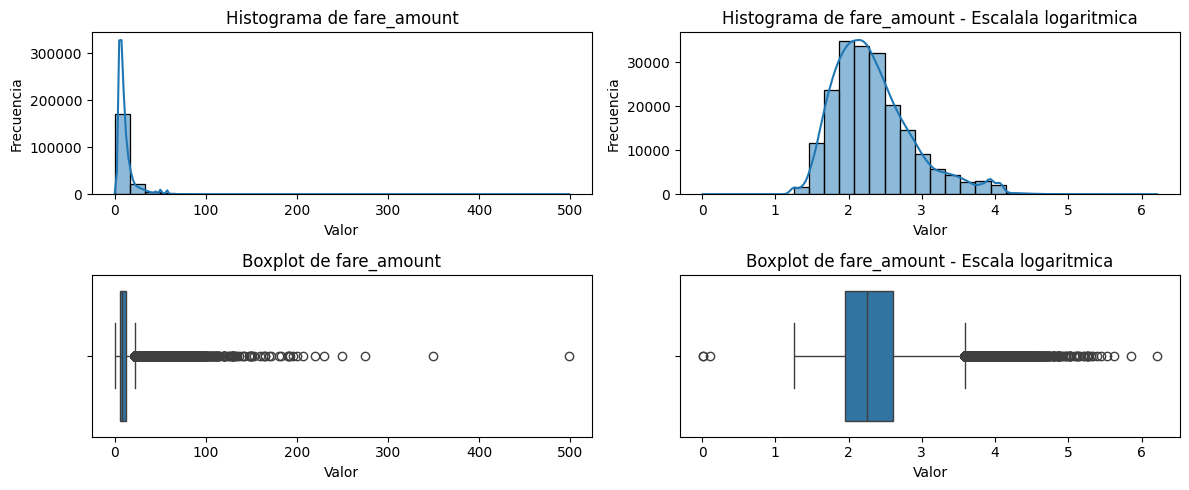



count    199978.000000
mean         11.362649
std           9.897079
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64


In [4]:
# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

# Histograma con KDE
sns.histplot(df['fare_amount'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Histograma de fare_amount')
axes[0,0].set_xlabel('Valor')
axes[0,0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df['fare_amount'], ax=axes[1,0])
axes[1,0].set_title('Boxplot de fare_amount')
axes[1,0].set_xlabel('Valor')

# Histograma con KDE
sns.histplot(np.log1p(df['fare_amount']), bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Histograma de fare_amount - Escalala logaritmica')
axes[0,1].set_xlabel('Valor')
axes[0,1].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=np.log1p(df['fare_amount']), ax=axes[1,1])
axes[1,1].set_title('Boxplot de fare_amount - Escala logaritmica')
axes[1,1].set_xlabel('Valor')


plt.tight_layout()
plt.show()


print('\n')
print(df['fare_amount'].describe())



## Variables relacionadas con fechas

Se elimina variable duplicada de fecha ya que no aporta nada distinto.

In [5]:
#Cambiamos tipo de dato de la fecha del viaje
df['date_c'] = pd.to_datetime(df['date'], errors='coerce').dt.round('s')

#Eliminamos pickup_datetime ya que es igual a la variable date
df = df.drop('pickup_datetime', axis=1)
print(df['date_c'].describe())

count                           199978
mean     2012-03-22 14:08:03.544569600
min                2009-01-01 01:15:22
25%                2010-08-25 09:17:00
50%         2012-03-21 20:28:03.500000
75%      2013-10-19 01:02:24.249999872
max                2015-06-30 23:40:39
Name: date_c, dtype: object


Se fragmenta la variable de fecha en variables relacionadas a ella para poder analizar la variable target en diferentes niveles.

In [6]:
df['hora']=df['date_c'].dt.hour
df['dia']=df['date_c'].dt.day
df['mes']=df['date_c'].dt.month
df['anio']=df['date_c'].dt.year
df['dia_semana']=df['date_c'].dt.dayofweek

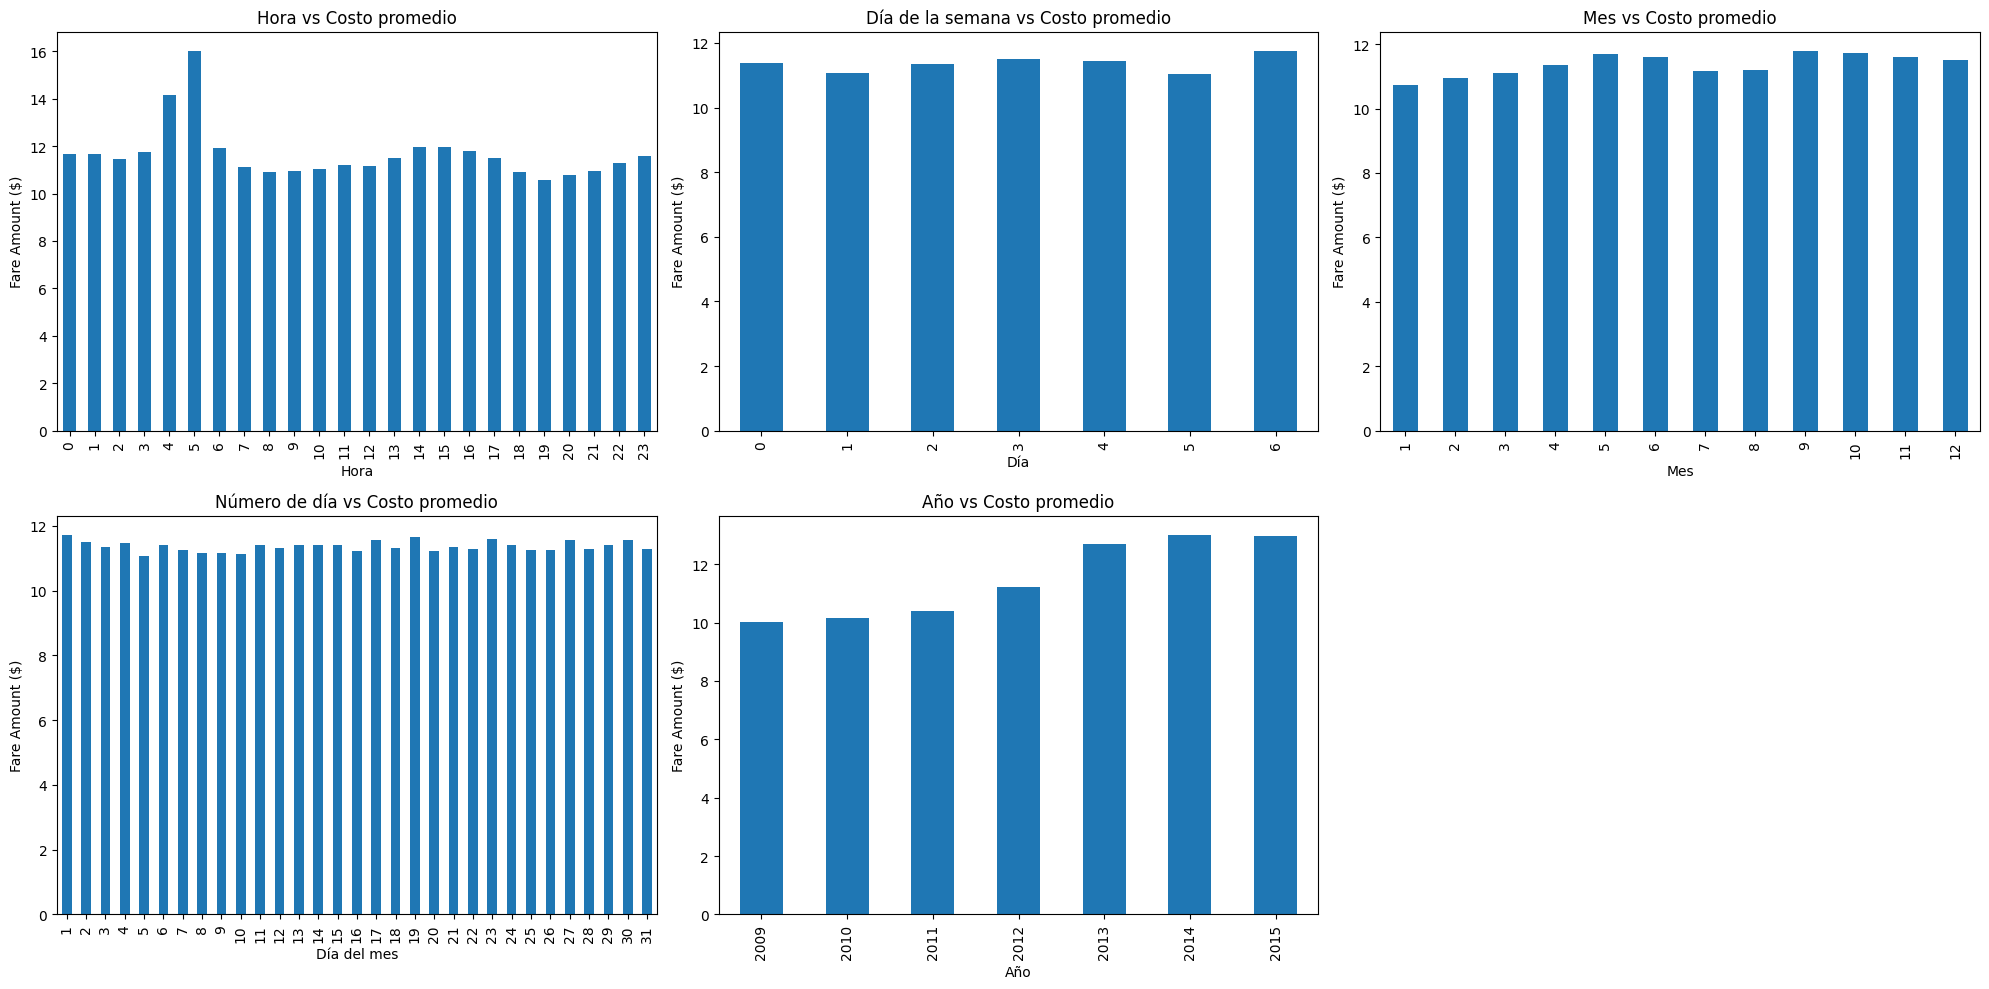

In [7]:
# Crear una figura con 6 subplots (en 2 filas de 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()  # Para acceder a los ejes como una lista simple

# 2. Costo promedio según hora
df.groupby('hora')['fare_amount'].mean().plot(kind='bar', ax=axes[0])
axes[0].set_title('Hora vs Costo promedio')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Fare Amount ($)')

# 3. Costo promedio según día de la semana
df.groupby('dia_semana')['fare_amount'].mean().plot(kind='bar', ax=axes[1])
axes[1].set_title('Día de la semana vs Costo promedio')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Fare Amount ($)')

# 4. Costo promedio según mes
df.groupby('mes')['fare_amount'].mean().plot(kind='bar', ax=axes[2])
axes[2].set_title('Mes vs Costo promedio')
axes[2].set_xlabel('Mes')
axes[2].set_ylabel('Fare Amount ($)')

# 5. Costo promedio según número del día del mes
df.groupby('dia')['fare_amount'].mean().plot(kind='bar', ax=axes[3])
axes[3].set_title('Número de día vs Costo promedio')
axes[3].set_xlabel('Día del mes')
axes[3].set_ylabel('Fare Amount ($)')

# 6. Costo promedio según año
df.groupby('anio')['fare_amount'].mean().plot(kind='bar', ax=axes[4])
axes[4].set_title('Año vs Costo promedio')
axes[4].set_xlabel('Año')
axes[4].set_ylabel('Fare Amount ($)')

axes[5].axis('off')

# Ajuste final
plt.tight_layout()
plt.show()

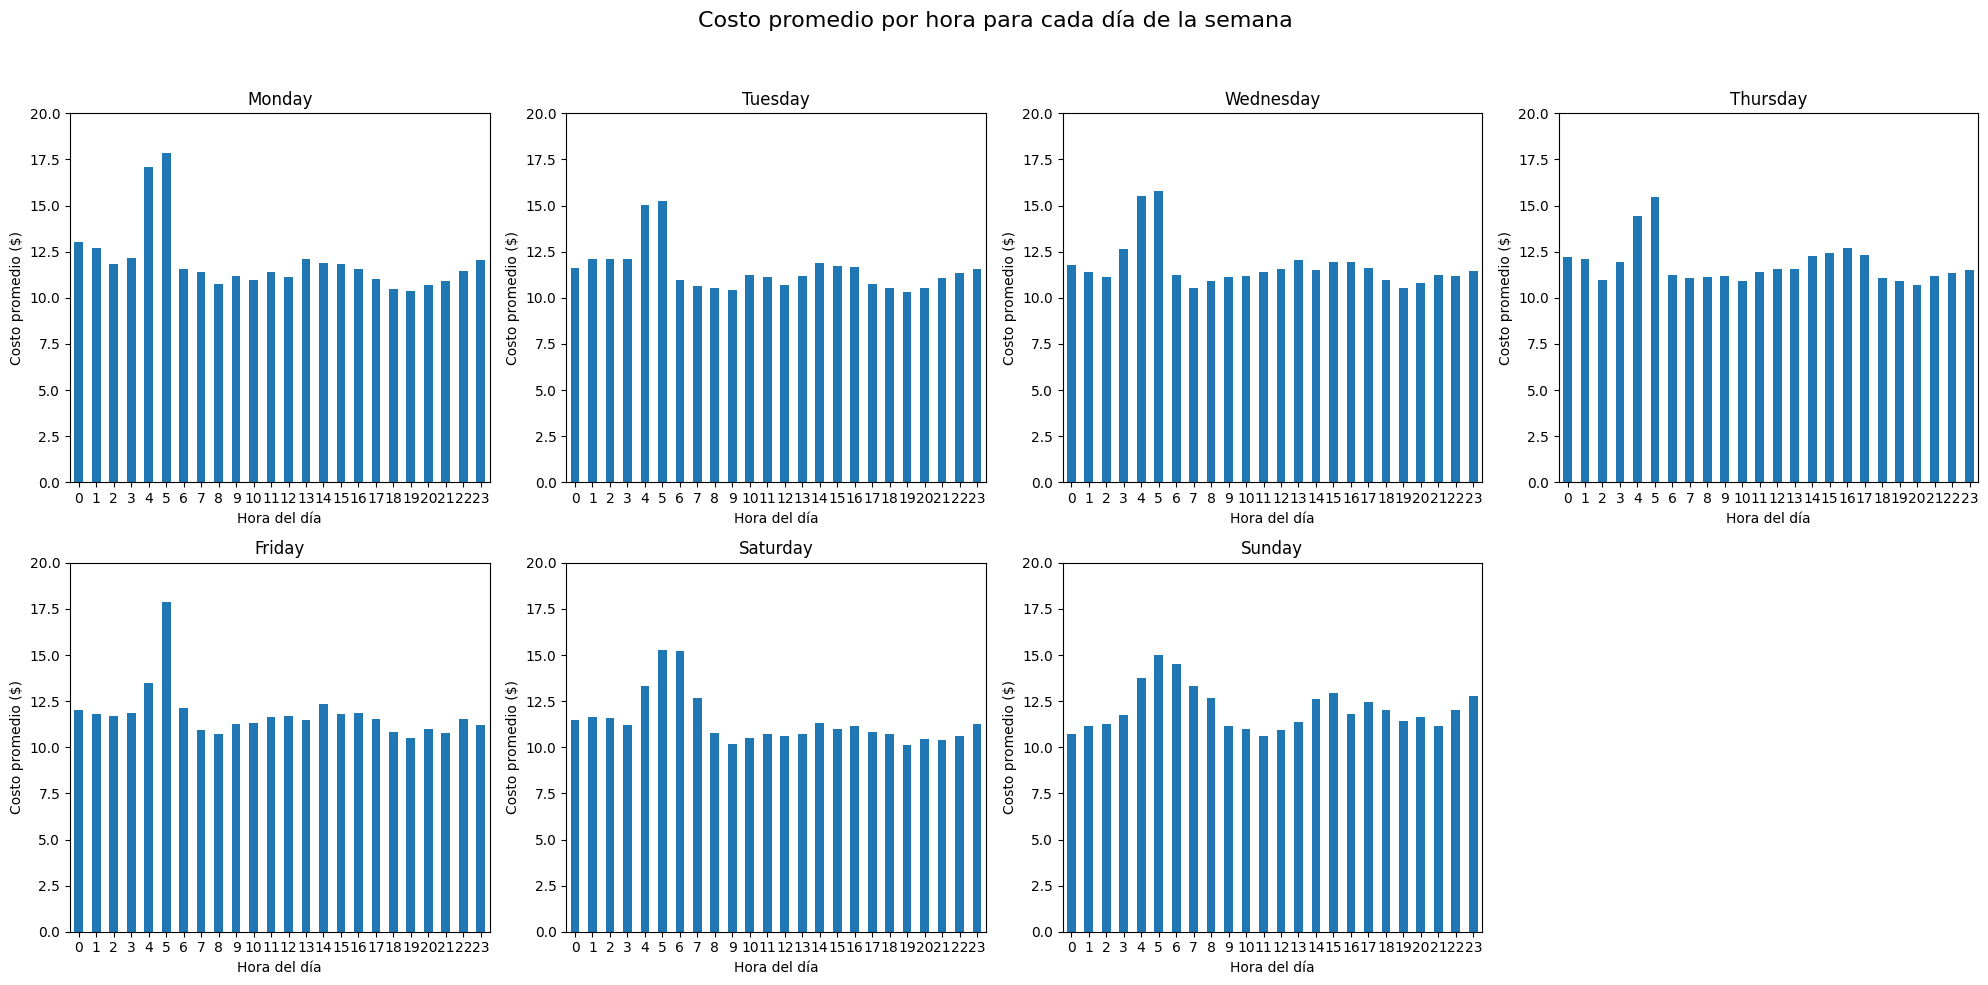

In [8]:
# Crea figura con 7 subplots (2 filas, 4 columnas para que entren bien)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Filtrar y graficar por cada día
for i, dia in enumerate(orden_dias):
    promedio_hora = df[df['dia_semana'] == i].groupby('hora')['fare_amount'].mean()
    promedio_hora.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{dia}')
    axes[i].set_xlabel('Hora del día')
    axes[i].set_ylabel('Costo promedio ($)')
    axes[i].set_xticks(range(0, 24))
    axes[i].set_xticklabels(range(0, 24), rotation=0)
    axes[i].set_ylim(0, 20)

# Eliminar el subplot vacío (posición 7 en índice, el 8vo gráfico)
axes[7].axis('off')

plt.suptitle('Costo promedio por hora para cada día de la semana', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Se visualiza variaciones en el promedio del precio dependiendo del horario del viaje.

Se visualiza un incremento en el promedio del precio en algunos horarios puntuales los fines de semana. Se grafica abajo como evoluciona el promedio del precio del viaje en funcion a como evolucionan las horas un dia de semana y un fin de semana.

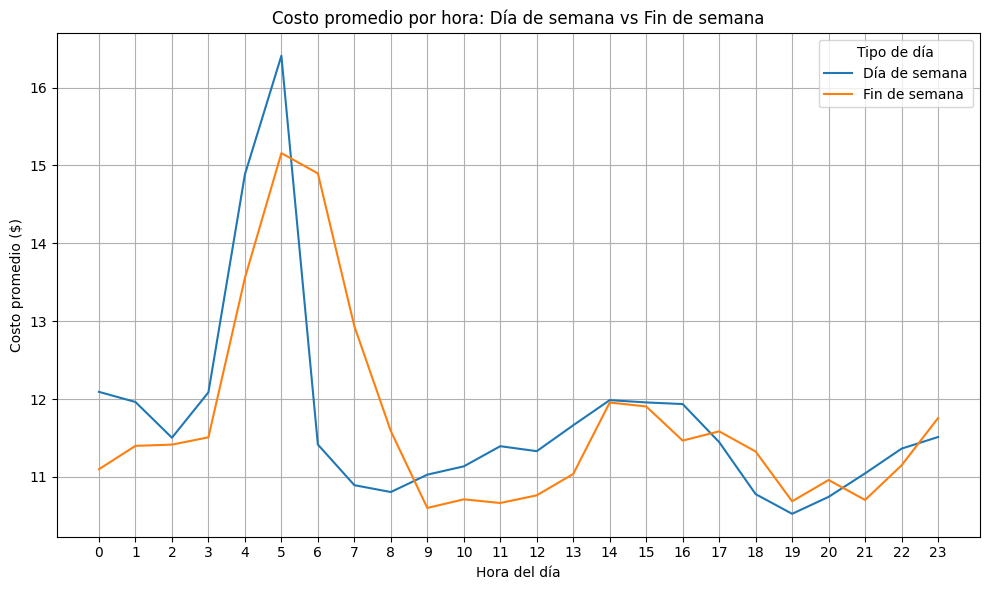

In [9]:
#creamos la varible es_finde
df['es_finde'] = df['date_c'].dt.dayofweek >= 5  # Sábado (5) y domingo (6)

# Agrupamos por es_finde y hora, calculando el costo promedio
promedio_finde = df.groupby(['es_finde', 'hora'])['fare_amount'].mean().reset_index()

# Cambiamos True/False por texto más claro
promedio_finde['es_finde'] = promedio_finde['es_finde'].map({True: 'Fin de semana', False: 'Día de semana'})

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=promedio_finde, x='hora', y='fare_amount', hue='es_finde')
plt.title('Costo promedio por hora: Día de semana vs Fin de semana')
plt.xlabel('Hora del día')
plt.ylabel('Costo promedio ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Tipo de día')
plt.tight_layout()
plt.show()

Se visualiza una diferencia en los precios entre los dias que no son fin de semana y los dias que son fin de semana. Se propone crear una variable llamada es_finde.

Tanto en el grafico de arriba como en este se identifica cambios relevantes en el costo promedio del viaje dependiendo la hora del mismo. Se crean dos variables, correspondiente a una codificacion ciclica, para el horario del viaje.

In [10]:
# Codificación cíclica para hora
df['hora_sin'] = np.sin(2 * np.pi * df['hora'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora'] / 24)

In [11]:
#Creamos variable para saber si el viaje se realizo un dia feriado
min_anio = min(df['date_c'].dt.year)
max_anio = max(df['date_c'].dt.year)
feriados = holidays.CountryHoliday('US',years=range(min_anio, max_anio + 1))
df['es_feriado'] = df['date_c'].dt.date.isin(feriados)

In [12]:
print('Cantidad de feriados y no feriados')
df['es_feriado'].value_counts()

Cantidad de feriados y no feriados


es_feriado
False    195454
True       4524
Name: count, dtype: int64

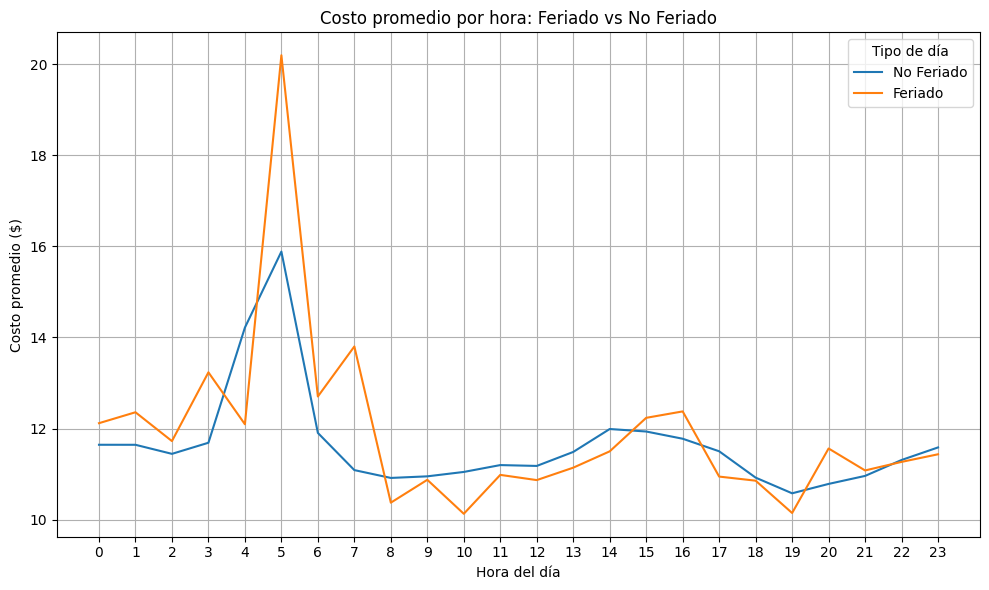

In [13]:
# Agrupamos por es_finde y hora, calculando el costo promedio
promedio_feriado = df.groupby(['es_feriado','hora'])['fare_amount'].mean().reset_index()

# Cambiamos True/False por texto más claro
promedio_feriado['es_feriado'] = promedio_feriado['es_feriado'].map({True: 'Feriado', False: 'No Feriado'})

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=promedio_feriado, x='hora', y='fare_amount', hue='es_feriado')
plt.title('Costo promedio por hora: Feriado vs No Feriado')
plt.xlabel('Hora del día')
plt.ylabel('Costo promedio ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Tipo de día')
plt.tight_layout()
plt.show()

En algunos rangos horarios parece haber una diferencia marcada entre el promedio del costo del viaje dependiendo si el dia es feriado o no. Se justifica la creacion de la variable es_feriado

## Variables en relacion a cantidad de pasajeros

El dataset cuenta con una variable que indica la cantidad de pasajeros que tuvo el viaje. Se limpia la variable para valores fisicamente imposibles. A partir de ella se decide crear y analizar las siguientes variables dummies:

*   mensajeria: indica si el viaje no tuvo pasajeros (viaje tipo delivery)
*   uber_xl: indica si el vehiculo utilizado es de gran capacidad (igual o mayor a 5 pasajeros)



### Mensajeria

Se encuentra un valor atipico para la variable cantidad de pasajeros.

In [14]:
#Observamos valores de las varaibles
print('Valores de la variable cantidad de pasajeros: ',df['passenger_count'].unique())
print('Registros con cantidad de pasajeros = 208: ',df[(df['passenger_count'] == 208)].shape[0])


Valores de la variable cantidad de pasajeros:  [  1   3   5   2   4   6   0 208]
Registros con cantidad de pasajeros = 208:  1


In [15]:
df.loc[df['passenger_count'] == 208,'passenger_count'] = np.nan
print('Registros con cantidad de pasajeros = 208: ',df[(df['passenger_count'] == 208)].shape[0])

Registros con cantidad de pasajeros = 208:  0


Se reemplaza por Nan el outlier. Luego se imputa

In [16]:
#Creamos variables en funcion a la cantidad de pasajeros
df['mensajeria'] = df['passenger_count'].apply(lambda x: True if x == 0 else False)
df.groupby('mensajeria')['fare_amount'].mean().reset_index()

,mensajeria,fare_amount
0,False,11.369419
1,True,9.459944


Al haber una diferencia en el costo promedio, que un viaje sea o no de tipo mensajeria podria influir en la variacion del precio. Se justifica la creacion de una variable que identifique si el viaje es de mensajeria.

### UberXL

In [17]:
df['uber_xl'] =  df['passenger_count'].apply(lambda x: True if x >= 5 else False)
print(df.groupby('uber_xl')['fare_amount'].mean().reset_index())
#df.drop(columns='uber_xl', inplace=True)

   uber_xl  fare_amount
0    False    11.355410
1     True    11.434627


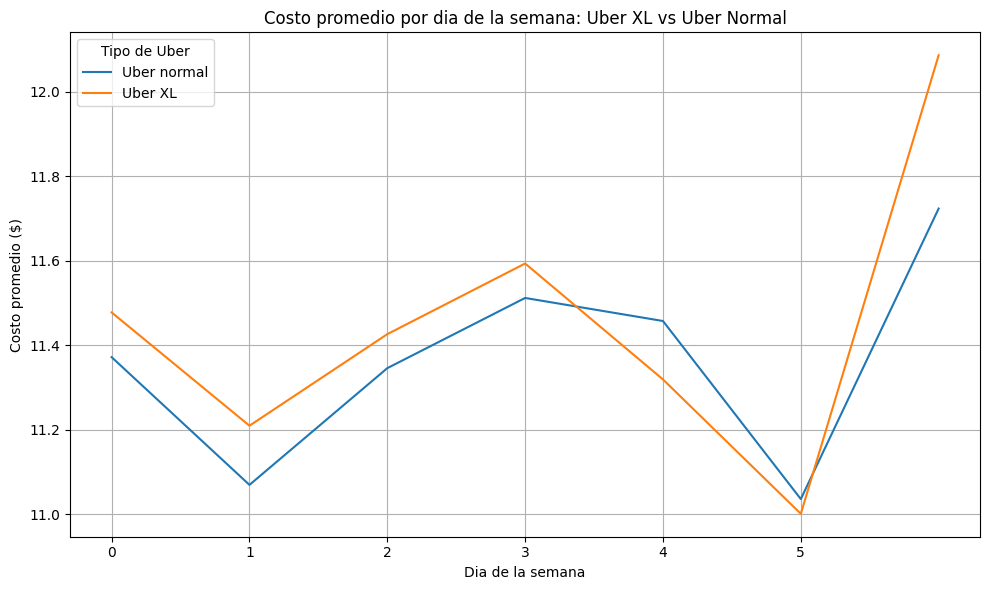

In [18]:
promedio_dia = df.groupby(['uber_xl','dia_semana'])['fare_amount'].mean().reset_index()

# Cambiamos True/False por texto más claro
promedio_dia['uber_xl'] = promedio_dia['uber_xl'].map({True: 'Uber XL', False: 'Uber normal'})

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=promedio_dia, x='dia_semana', y='fare_amount', hue='uber_xl')
plt.title('Costo promedio por dia de la semana: Uber XL vs Uber Normal')
plt.xlabel('Dia de la semana')
plt.ylabel('Costo promedio ($)')
plt.xticks(range(0, 6))
plt.grid(True)
plt.legend(title='Tipo de Uber')
plt.tight_layout()
plt.show()

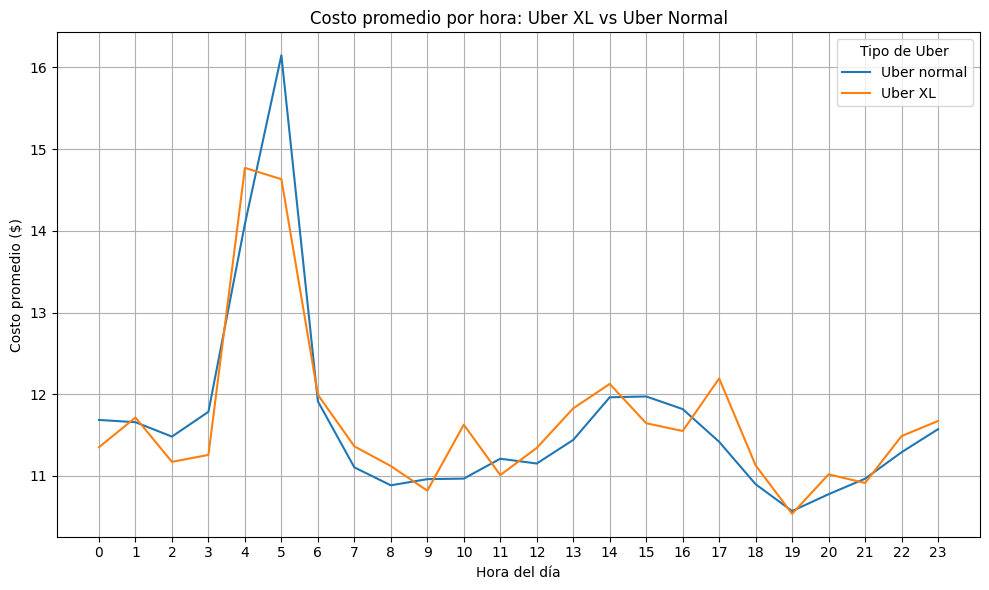

In [19]:
promedio_feriado = df.groupby(['uber_xl','hora'])['fare_amount'].mean().reset_index()

# Cambiamos True/False por texto más claro
promedio_feriado['uber_xl'] = promedio_feriado['uber_xl'].map({True: 'Uber XL', False: 'Uber normal'})

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=promedio_feriado, x='hora', y='fare_amount', hue='uber_xl')
plt.title('Costo promedio por hora: Uber XL vs Uber Normal')
plt.xlabel('Hora del día')
plt.ylabel('Costo promedio ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Tipo de Uber')
plt.tight_layout()
plt.show()

Al analizar el costo promedio de los viajes de los UberXL vs. un Uber comun a diferentes niveles de agrupacion, se observan pequeñas diferencias de variacion. Podria llegar a ser una variable que ayude a determinar el precio de un viaje. Se decide crear una variable para distinguir si un viaje se realiza o no con un UberXL.

## Variables en relacion a los puntos de inicio y fin del viaje

El dataset cuenta con 4 columnas que indican el punto de coordenadas de inicio y fin del viaje. Analizando el dataset se puede observar que los viajes son principalmente en la ciudad de New York (USA). 
A partir de las cuatro columnas se decide crear una variable llamada distancia_viaje_km que indica la distancia en kilometros del punto de inicio al punto de fin. 

In [ ]:
#Graficamos los puntos para observan donde se concentran los viajes del dataset
fig = px.scatter_mapbox(df, lat="pickup_latitude", lon="pickup_longitude", zoom=8, mapbox_style="open-street-map")
fig.update_layout(mapbox_center={"lat": 40.748, "lon": -73.985}, margin=dict(l=0, r=0, t=0, b=0))
fig.show()

Se detectaron algunos viajes (al rededor de 4000) en donde alguna de sus coordenadas indican que se ubican fuera de dicha area. En posteriores pasos se analizar en detalle las distancias y se toman decisiones al respecto.

Se calcula distancia Manhattan

In [21]:
def manhattan_distance_km(lat1, lon1, lat2, lon2):
    lat_diff_km = 111 * abs(lat1 - lat2)
    mean_lat_rad = np.radians((lat1 + lat2) / 2)
    lon_diff_km = 111 * np.cos(mean_lat_rad) * abs(lon1 - lon2)
    return lat_diff_km + lon_diff_km

In [22]:
df['distancia_viaje_km'] = df.apply(
    lambda x: manhattan_distance_km(
        x['pickup_latitude'], x['pickup_longitude'],
        x['dropoff_latitude'], x['dropoff_longitude']
    ), axis=1
)

## Dividimos dataset para calcular modelos

Se divide el dataset para poder entrenar y testear los modelos.

In [23]:
#Dividimos dataset en conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

#df_train = X_train.join(y_train)

## Imputacion de valores

### Cantidad de pasajeros

In [24]:
X_train.columns

Index(['key', 'date', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'date_c',
       'hora', 'dia', 'mes', 'anio', 'dia_semana', 'es_finde', 'hora_sin',
       'hora_cos', 'es_feriado', 'mensajeria', 'uber_xl',
       'distancia_viaje_km'],
      dtype='object')

Se imputa por la mediana el valor en Nan detectado anteriormente

In [25]:
mediana_pasajeros_train = X_train['passenger_count'].median()
X_train.loc[X_train['passenger_count'].isna(),'passenger_count'] = mediana_pasajeros_train

### Distancias

Reemplazo por cero los valores nan de distancia

In [26]:
X_train.loc[X_train['distancia_viaje_km'].isna(),'distancia_viaje_km'] = 0
X_test.loc[X_test['distancia_viaje_km'].isna(),'distancia_viaje_km'] = 0

Calculo mediana de la distancia pero solo teniendo en cuenta los valores mayores a cero

In [27]:
mediana_distancia = X_train[X_train['distancia_viaje_km']>0]['distancia_viaje_km'].median()

Imputamos con la mediana los valores menores o iguales a cero

In [28]:
print('Cantidad de distancias menores o iguales a cero en X_train: ', X_train[X_train['distancia_viaje_km']<=0].shape[0])

Cantidad de distancias menores o iguales a cero en X_train:  4522


In [29]:
X_train.loc[    X_train['distancia_viaje_km']<=0
                ,'distancia_viaje_km'] = mediana_distancia

In [30]:
print('Cantidad de distancias menores o iguales a cero en X_test: ', X_test[X_test['distancia_viaje_km']<=0].shape[0])

Cantidad de distancias menores o iguales a cero en X_test:  1110


In [31]:
X_test.loc[    X_test['distancia_viaje_km']<=0
                ,'distancia_viaje_km'] = mediana_distancia

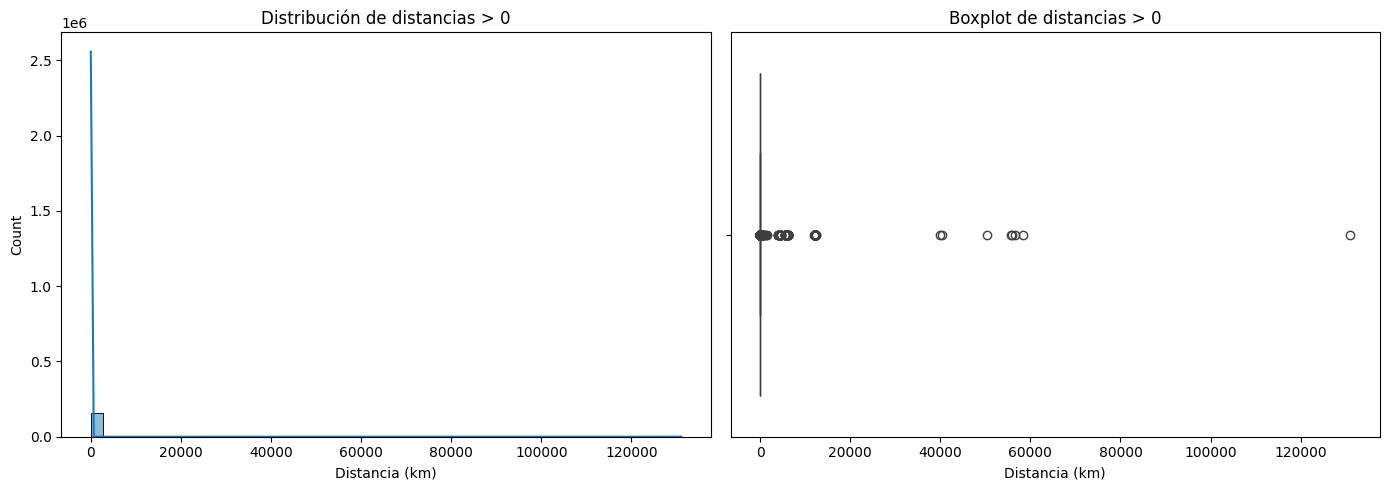

In [32]:
# Filtrar datos
distancias = X_train['distancia_viaje_km']#X_train[X_train['distancia_viaje_km'] > 0]['distancia_viaje_km']

# Crear figura con 2 gráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma + KDE
sns.histplot(distancias, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribución de distancias > 0")
axes[0].set_xlabel("Distancia (km)")

# Boxplot
sns.boxplot(x=distancias, ax=axes[1])
axes[1].set_title("Boxplot de distancias > 0")
axes[1].set_xlabel("Distancia (km)")

plt.tight_layout()
plt.show()

Se observa que la distrubucion es muy asimetrica. Se analizan algunos cuantiles.

In [33]:
quantil = [0.8, 0.9, 0.99, 0.995, 0.996, 0.997, 0.998, 0.999]
for q in quantil:
    print('Cuantil',q,':' ,X_train['distancia_viaje_km'].quantile(q))

Cuantil 0.8 : 5.8956701883543206
Cuantil 0.9 : 8.971982643125884
Cuantil 0.99 : 28.705346803569068
Cuantil 0.995 : 30.612686340173063
Cuantil 0.996 : 31.783342226711436
Cuantil 0.997 : 35.36631886928173
Cuantil 0.998 : 6212.764398357164
Cuantil 0.999 : 12221.157465873748


Se visualiza un cambio abrupto en el cuantil del 99,7%. Se toma como outlier el limite establecido por dicho cuantil. Si el viaje tiene un recorrido mayor a 35.36 km, se elimina de mi dataset para evitar distorsiones ya que no resulta un porcentaje significativo del total (0,3%). Se ha probado con imputar pero las metricas han sido peores.

In [34]:
quantil997 = X_train['distancia_viaje_km'].quantile(0.997)
filtro_quantil997_train = X_train['distancia_viaje_km'] < quantil997
filtro_quantil997_test = X_test['distancia_viaje_km'] < quantil997


In [35]:
X_train = X_train[filtro_quantil997_train]
y_train = y_train[filtro_quantil997_train]

X_test = X_test[filtro_quantil997_test]
y_test = y_test[filtro_quantil997_test]

Se realiza el mismo analisis pero con cuantiles bajos

In [36]:
quantil = [0.001, 0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
for q in quantil:
    print('Cuantil',q,':' ,X_train['distancia_viaje_km'].quantile(q))

Cuantil 0.001 : 0.0019422952976194268
Cuantil 0.002 : 0.007211057798503629
Cuantil 0.003 : 0.02433378394549061
Cuantil 0.004 : 0.04815871827448958
Cuantil 0.005 : 0.08749570388844115
Cuantil 0.006 : 0.1266438252938299
Cuantil 0.007 : 0.17507712897582783
Cuantil 0.008 : 0.21202173786214087
Cuantil 0.009 : 0.2527014133020392
Cuantil 0.01 : 0.28643653695708265


Se visualiza que el 0,6% de los viajes tienen una distancia menor a 0.12km (en otras palabras, menores a una cuadra). Dicha situacion resulta sospechosa. Se toma como outlier el limite establecido por el cuantil el 0,6%. Si el vije tiene un recorrido menor a 0.12 km, se elimina de mi dataset para evitar distorsiones ya que no representa un porcentaje significativo del total. Se ha probado con imputar pero las metricas han resultado peores.

In [37]:
quantil_bajo = X_train['distancia_viaje_km'].quantile(0.006)
print(quantil_bajo)
filtro_quantilbajo_train = X_train['distancia_viaje_km'] > quantil_bajo
filtro_quantilbajo__test = X_test['distancia_viaje_km'] > quantil_bajo

0.1266438252938299


In [38]:
X_train = X_train[filtro_quantilbajo_train]
y_train = y_train[filtro_quantilbajo_train]

X_test = X_test[filtro_quantilbajo__test]
y_test = y_test[filtro_quantilbajo__test]

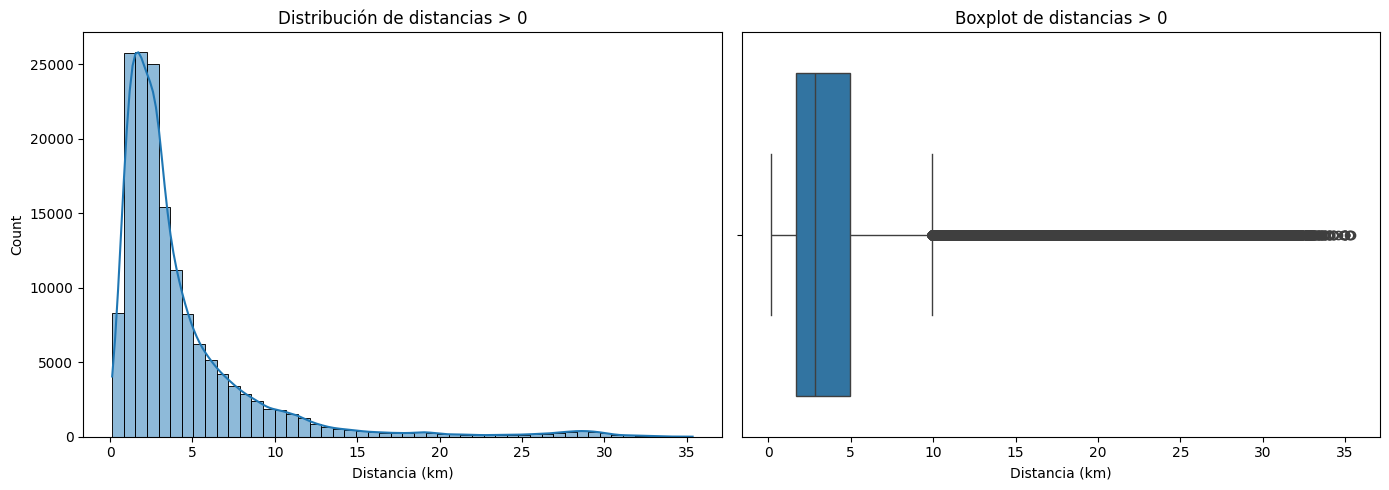

In [39]:
# Filtrar datos
distancias = X_train['distancia_viaje_km']#X_train[X_train['distancia_viaje_km'] > 0]['distancia_viaje_km']

# Crear figura con 2 gráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma + KDE
sns.histplot(distancias, bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribución de distancias > 0")
axes[0].set_xlabel("Distancia (km)")

# Boxplot
sns.boxplot(x=distancias, ax=axes[1])
axes[1].set_title("Boxplot de distancias > 0")
axes[1].set_xlabel("Distancia (km)")

plt.tight_layout()
plt.show()

Chequeamos valores faltantes

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158544 entries, 183960 to 121969
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   key                 158544 non-null  int64         
 1   date                158544 non-null  object        
 2   pickup_longitude    158544 non-null  float64       
 3   pickup_latitude     158544 non-null  float64       
 4   dropoff_longitude   158543 non-null  float64       
 5   dropoff_latitude    158543 non-null  float64       
 6   passenger_count     158544 non-null  float64       
 7   date_c              158544 non-null  datetime64[ns]
 8   hora                158544 non-null  int32         
 9   dia                 158544 non-null  int32         
 10  mes                 158544 non-null  int32         
 11  anio                158544 non-null  int32         
 12  dia_semana          158544 non-null  int32         
 13  es_finde            158544 no

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39685 entries, 123358 to 124642
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 39685 non-null  int64         
 1   date                39685 non-null  object        
 2   pickup_longitude    39685 non-null  float64       
 3   pickup_latitude     39685 non-null  float64       
 4   dropoff_longitude   39685 non-null  float64       
 5   dropoff_latitude    39685 non-null  float64       
 6   passenger_count     39685 non-null  float64       
 7   date_c              39685 non-null  datetime64[ns]
 8   hora                39685 non-null  int32         
 9   dia                 39685 non-null  int32         
 10  mes                 39685 non-null  int32         
 11  anio                39685 non-null  int32         
 12  dia_semana          39685 non-null  int32         
 13  es_finde            39685 non-null  bool     

## Escalado

Todas nuestras valiables son dummies excepto distancia_viaje_km. Se decide escalar dicha variable, utilizando el metodo MinMax, para que todas las variables del dataset tengan sus valores distribuidos entre el 0 y el 1.

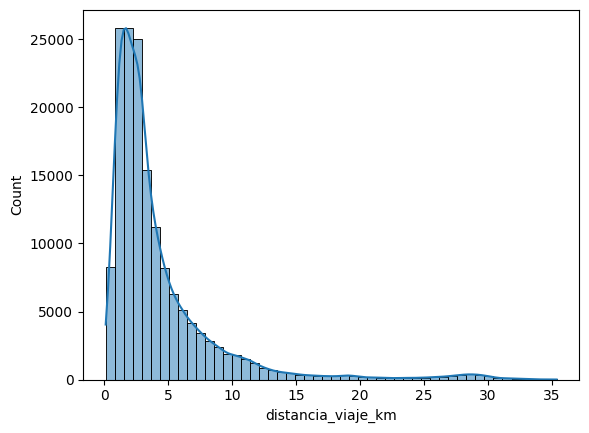

In [42]:
sns.histplot(X_train['distancia_viaje_km'], bins=50, kde=True)
plt.show()

In [43]:
#Escalamos distancia en un rango de 0 y 1 ya que todas nuestras variables restantes se encuentran en dicho intervalo
scaler_train = MinMaxScaler()
X_train[['distancia_viaje_km_escalada']] = scaler_train.fit_transform(X_train[['distancia_viaje_km']])
X_test[['distancia_viaje_km_escalada']] = scaler_train.transform(X_test[['distancia_viaje_km']])
#X_val[['distancia_viaje_km_escalada']] = scaler_train.transform(X_val[['distancia_viaje_km']])

In [44]:
#Escalamos variables de hora
X_train[['hora_sin']] = scaler_train.fit_transform(X_train[['hora_sin']])
X_test[['hora_sin']] = scaler_train.transform(X_test[['hora_sin']])
#X_val[['hora_sin']] = scaler_train.transform(X_val[['hora_sin']])

X_train[['hora_cos']] = scaler_train.fit_transform(X_train[['hora_cos']])
X_test[['hora_cos']] = scaler_train.transform(X_test[['hora_cos']])
#X_val[['hora_cos']] = scaler_train.transform(X_val[['hora_cos']])

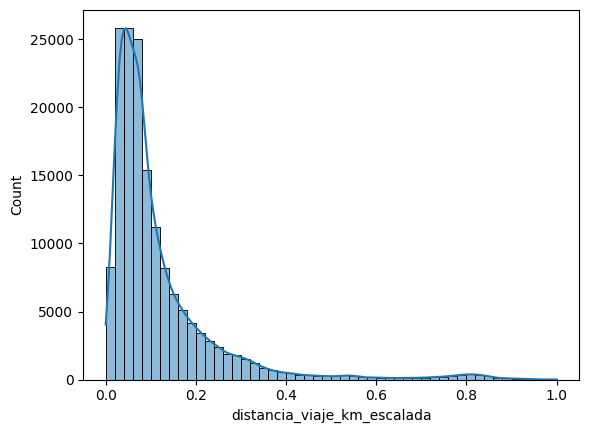

In [45]:
sns.histplot(X_train['distancia_viaje_km_escalada'], bins=50, kde=True)
plt.show()

In [46]:
X_train[['es_finde', 'hora_sin', 'hora_cos', 'es_feriado', 'mensajeria','uber_xl' ,'distancia_viaje_km_escalada']].describe()

,hora_sin,hora_cos,distancia_viaje_km_escalada
count,158544.000000,158544.000000,158544.000000
mean,0.402370,0.465574,0.117811
std,0.334300,0.357111,0.131390
min,0.000000,0.000000,0.000000
25%,0.066987,0.146447,0.043967
50%,0.370590,0.370590,0.075913
75%,0.750000,0.853553,0.137504
max,1.000000,1.000000,1.000000


## Matriz de correlacion





In [47]:
X_train.columns

Index(['key', 'date', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'date_c',
       'hora', 'dia', 'mes', 'anio', 'dia_semana', 'es_finde', 'hora_sin',
       'hora_cos', 'es_feriado', 'mensajeria', 'uber_xl', 'distancia_viaje_km',
       'distancia_viaje_km_escalada'],
      dtype='object')

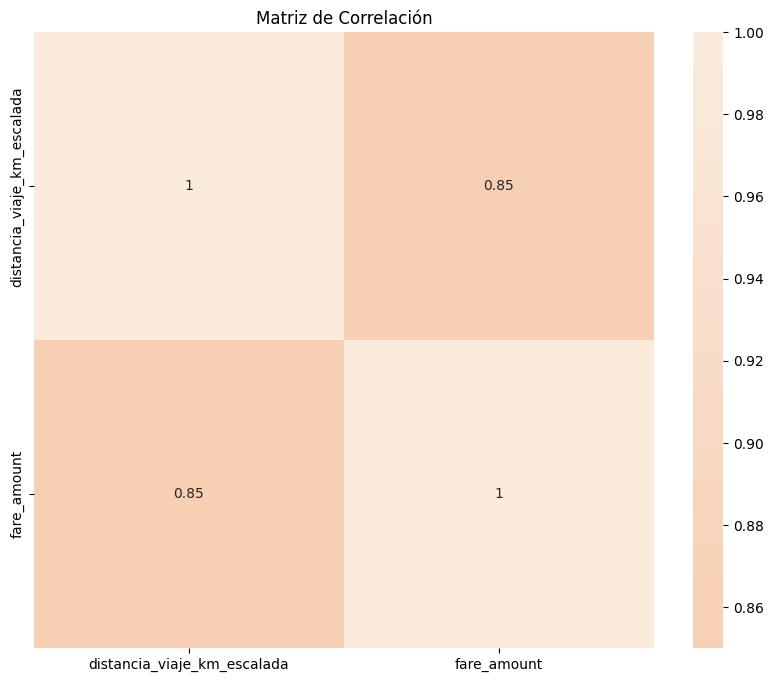

In [48]:
df_correlacion = pd.concat([X_train, y_train], axis=1)
data_correlacion = df_correlacion[['distancia_viaje_km_escalada','fare_amount']].corr().round(2)
plt.figure(figsize=(10, 8))
plt.title('Matriz de Correlación')
sns.heatmap(data_correlacion, annot=True, cmap="rocket", center=0)
plt.show()

## LINEAR REGRESION

In [289]:
X_train.columns

Index(['key', 'date', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'date_c',
       'hora', 'dia', 'mes', 'anio', 'dia_semana', 'es_finde', 'hora_sin',
       'hora_cos', 'es_feriado', 'mensajeria', 'uber_xl', 'distancia_viaje_km',
       'distancia_viaje_km_escalada'],
      dtype='object')

In [49]:
X_variables = ['es_finde', 'hora_sin', 'hora_cos', 'es_feriado', 'mensajeria', 'distancia_viaje_km_escalada', 'uber_xl']
X_train = X_train[X_variables]
X_test = X_test[X_variables]
#X_val = X_val[X_variables]

lr = LinearRegression()
lr.fit(X_train, y_train)

r2_train_lr = lr.score(X_train, y_train)
r2_test_lr = lr.score(X_test, y_test)
print('R2 - Train: ', r2_train_lr)
print('R2 - Test: ', r2_test_lr)


y_pred = lr.predict(X_test)

#MSE
mse_lr = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE): ", mse_lr)

#RMSE
rmse_lr = np.sqrt(mse_lr)
print("Raíz del error cuadrático medio (RMSE): ", rmse_lr)

#MAPE
mape_lr = mean_absolute_percentage_error(y_test, y_pred)
print("Error porcentual medio (MAPE): {:.2f}%".format(mape_lr * 100))


R2 - Train:  0.7314518585356857
R2 - Test:  0.7336545859820635
Error cuadrático medio (MSE):  24.328795056235197
Raíz del error cuadrático medio (RMSE):  4.932422838345796
Error porcentual medio (MAPE): 29.14%


Se observa un R2 de 0,73 tanto en train como en test, esto significa que el modelo explica el 73% de la variabilidad de la variable objetivo (fare_amount) en ambos conjuntos. No hay sobreajuste ni subajuste, ya que el desempeño es similar entre ambos datasets. Sin embargo, un 27% de la variabilidad de la variable target queda sin explicar, lo que sugiere que hay factores importantes no capturados por el modelo.


El RMSE nos dice que, en promedio, el modelo se equivoca por 4.93 dolares al predecir el costo de un viaje.


El MAPE = 29,14 significa que el modelo comete, en promedio, un error del 29,14% respecto al valor real al predecir el costo de un viaje.

## RIDGE

In [50]:
ridge =  RidgeCV(  alphas = np.logspace(-6, 6, 200)
                    ,fit_intercept   = True
                    #,store_cv_results = True
                    ,store_cv_values = True
                
                    )
_ = ridge.fit(X_train, y_train)

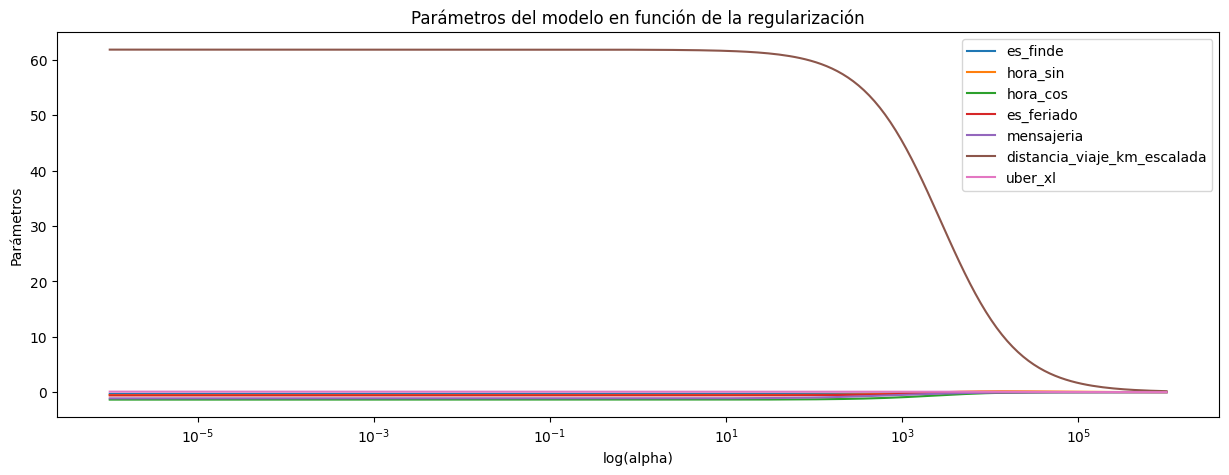

In [51]:
# Evolución de los parámetros en función de alpha

alphas = ridge.alphas
coefs = []

for alpha in alphas:
    modelo_aux = Ridge(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

Se observa como a medida que aumenta el alpha, los parametros van tendiendo a cero. Ademas, se observa un gran peso de la variable distancia_viaje_km_escalada en comparacion con las restantes.

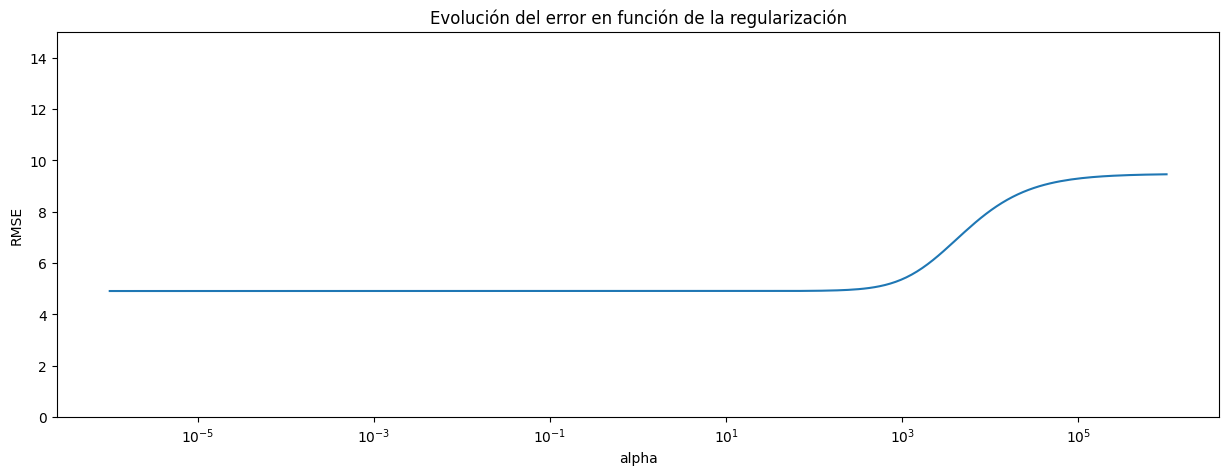

In [52]:
# Evolución del error de validación cruzada en función de alpha

# modelo.cv_values almacena el MSE de CV para cada valor de alpha.

mse_cv = ridge.cv_values_.reshape((-1, 200)).mean(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse_ridge     = np.min(rmse_cv)
#optimo       = mod.alphas[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ridge.alphas, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([0,15])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

In [53]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {ridge.alpha_}")
print("RMSE de VC: ", min_rmse_ridge)

r2_train_ridge = ridge.score(X_train, y_train)
r2_test_ridge = ridge.score(X_test, y_test)


print("\nR2 - Train: ", r2_train_ridge )
print("R2 - Test: ", r2_test_ridge)


y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print("RMSE: ", rmse_ridge)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_ridge)
print("Error porcentual medio (MAPE): {:.2f}%".format(mape_lr * 100))

Mejor valor de alpha encontrado: 0.07663410868007446
RMSE de VC:  4.912919202602751

R2 - Train:  0.7314518579549297
R2 - Test:  0.7336542447766357
RMSE:  4.932425997718582
Error porcentual medio (MAPE): 29.14%


No se observan mejoras al aplicar regularizacion

In [54]:
df_coeficientes_ridge = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': ridge.coef_.flatten()}
                  )

df_coeficientes_ridge[df_coeficientes_ridge.coef != 0]

,predictor,coef
0,es_finde,-0.308150
1,hora_sin,-0.533693
2,hora_cos,-1.352695
3,es_feriado,-0.590861
4,mensajeria,-1.120761
5,distancia_viaje_km_escalada,61.849887
6,uber_xl,0.090224


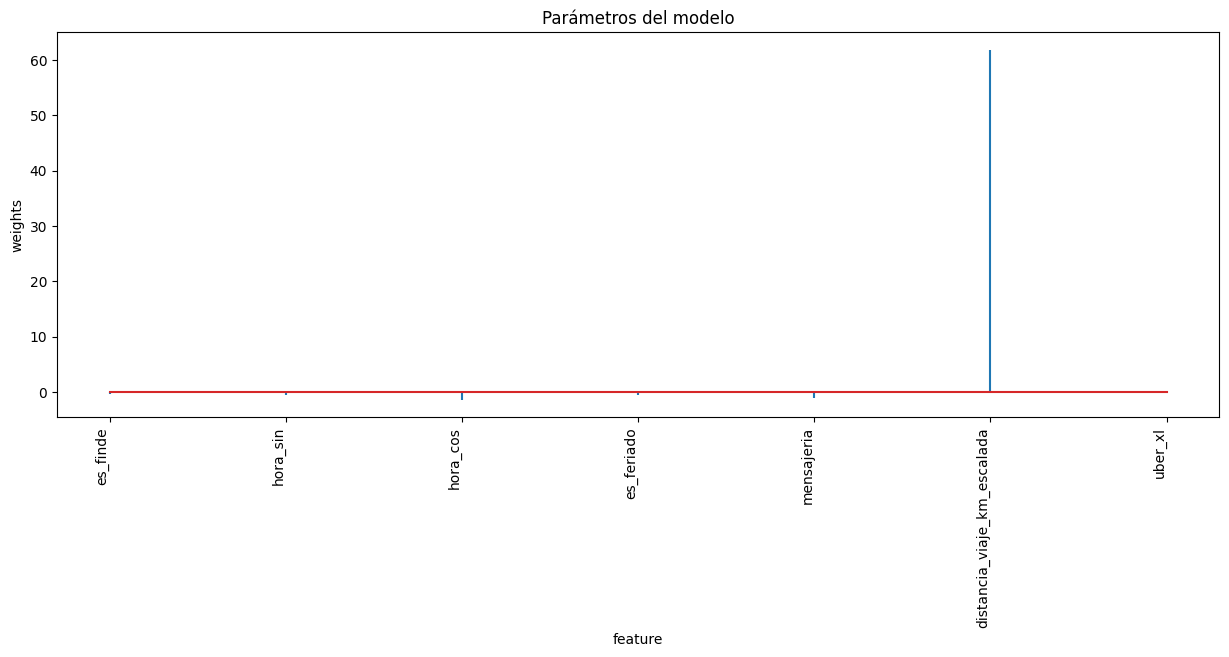

In [55]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame({'predictor': X_variables,'coef': ridge.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

Se observa una gran diferencia en el valor del parametro de la variable distancia_viaje_km_escalada por sobre las restantes.

## LASSO

In [56]:
#lassoCV = LassoCV()  # alpha controla la fuerza de la regularización L1 (Lasso)

lassoCV = LassoCV(alphas=np.logspace(-10, 6, 200))
_ = lassoCV.fit(X_train, y_train)

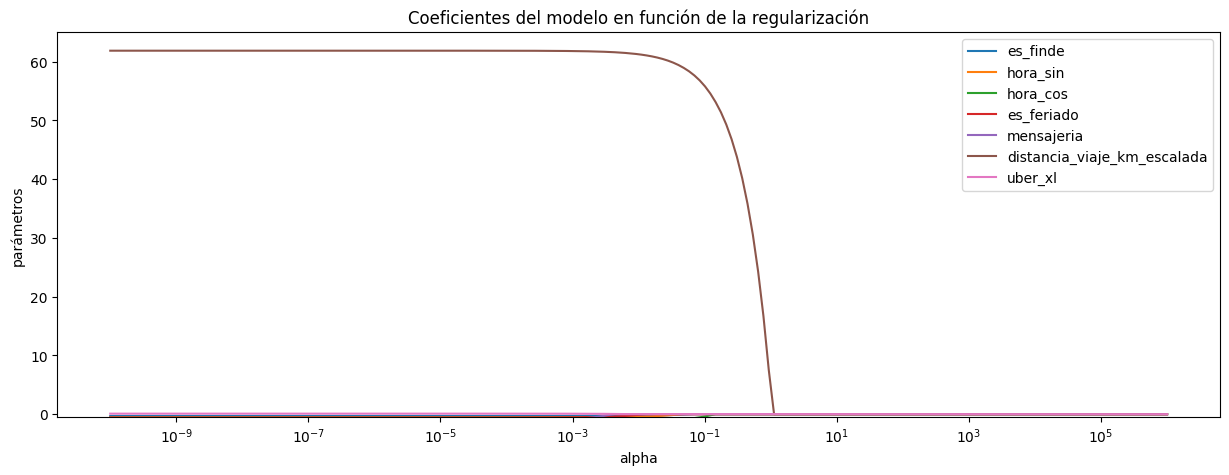

In [57]:
# Evolución de los parámetros en función de alpha

alphas = lassoCV.alphas_
coefs = []

for alpha in alphas:
    modelo_aux = Lasso(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Se observa como a medida que aumenta el alpha, los parametros van tendiendo a cero. Ademas, se observa un gran peso de la variable distancia_viaje_km_escalada en comparacion con las restantes.

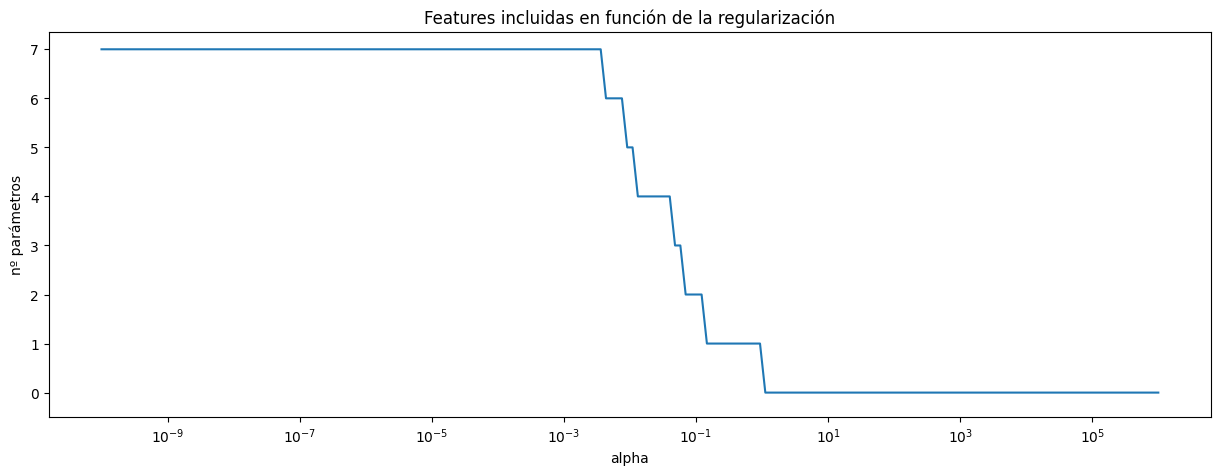

In [58]:
# Número de features incluidas (parámetros !=0) en función de alpha
alphas = lassoCV.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux =  Lasso(alpha=alpha)
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')
plt.show()

Se puede observar como se van eliminando las variables del modelo (debido a que sus parametros toman valor 0) a medida que va aumentando el alfa. Antes de que alfa sea igual a 10, ya todos los parametros toman valor 0.

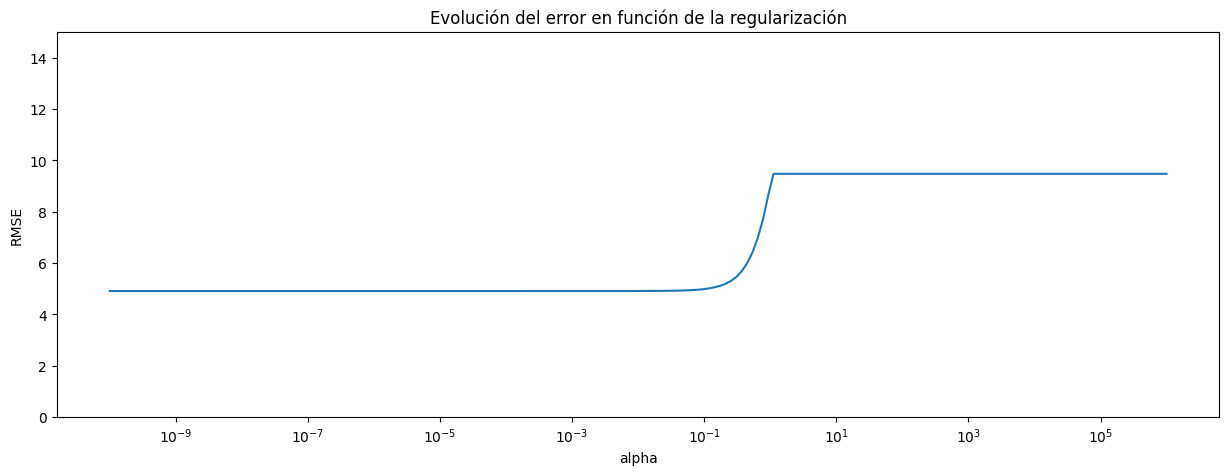

In [59]:
# Evolución del error de validación cruzada en función de alpha

#mse_path almacena el MSE de CV para cada valor de alpha.
mse_cv = lassoCV.mse_path_.mean(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)

# Se identifica el mejor
min_rmse_lasso     = np.min(rmse_cv)
#optimo       = lassoCV.alphas_[np.argmin(rmse_cv)]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(lassoCV.alphas_, rmse_cv)
ax.set_xscale('log')
ax.set_ylim([0,15])
ax.set_title('Evolución del error en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.show()

No se visualiza una mejora significativa en el error al aplicar regularizacion.

In [60]:
# Mejor valor alpha encontrado

print(f"Mejor valor de alpha encontrado: {lassoCV.alpha_}")

Mejor valor de alpha encontrado: 1e-10


In [61]:
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': lassoCV.coef_.flatten()}
                  )

df_coeficientes_lasso[df_coeficientes_lasso.coef != 0]

,predictor,coef
0,es_finde,-0.308159
1,hora_sin,-0.533724
2,hora_cos,-1.352740
3,es_feriado,-0.590893
4,mensajeria,-1.120891
5,distancia_viaje_km_escalada,61.851629
6,uber_xl,0.090223


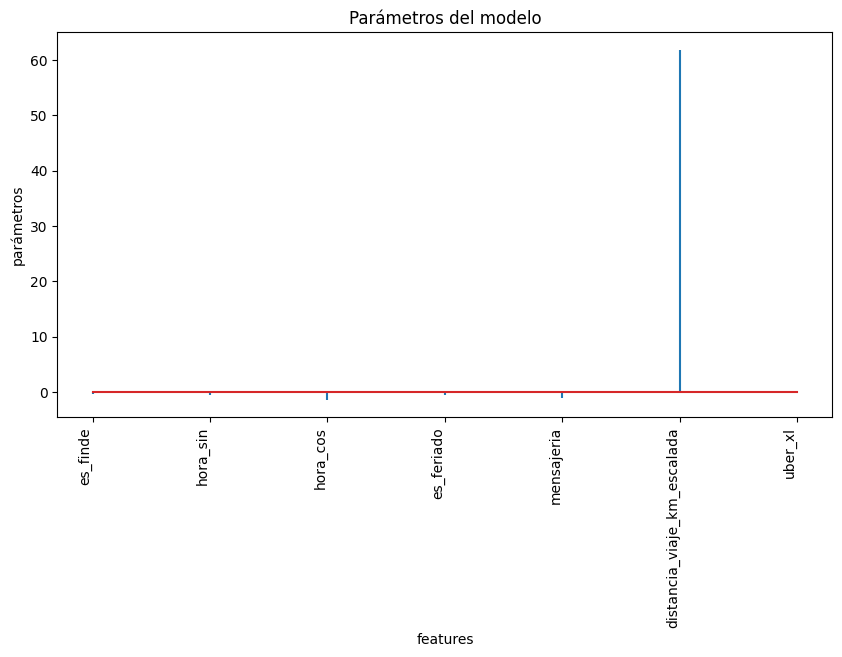

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('features')
ax.set_ylabel('parámetros')
ax.set_title('Parámetros del modelo');

Se observa una gran diferencia en el valor del parametro de la variable distancia_viaje_km_escalada por sobre las restantes.

In [63]:
# Error de test del modelo

r2_train_lasso = lassoCV.score(X_train, y_train)
r2_test_lasso = lassoCV.score(X_test, y_test)


print("\nR2 - Train: ", r2_train_lasso )
print("R2 - Test: ", r2_test_lasso)

y_pred = lassoCV.predict(X_test)
mse_lasso = mean_squared_error(y_test,y_pred)
rmse_lasso = np.sqrt(mse_lasso)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


R2 - Train:  0.7314518585356857
R2 - Test:  0.7336545859807997

El error (rmse) de test es: 4.932422838357498


No se visualiza mejoras en las metricasal aplicar regularizacion Lasso

## GRADIENTE DESCENDIENTE

### Preparacion de datos

In [64]:
columnas = ['es_finde','es_feriado','mensajeria','uber_xl']
X_train[columnas]=X_train[columnas].astype(np.uint8)
X_test[columnas]=X_test[columnas].astype(np.uint8)

In [ ]:
X_train_np= X_train.values.reshape(-1, len(X_train.columns))
y_train_np= y_train.values.reshape(-1, 1)
#X_val_np= X_val.values.reshape(-1, len(X_val.columns))
#y_val_np= y_val.values.reshape(-1, 1)
X_test_np= X_test.values.reshape(-1, len(X_test.columns))
y_test_np= y_test.values.reshape(-1, 1)

### Gradiente Descendiente

In [78]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W, train_errors, test_errors

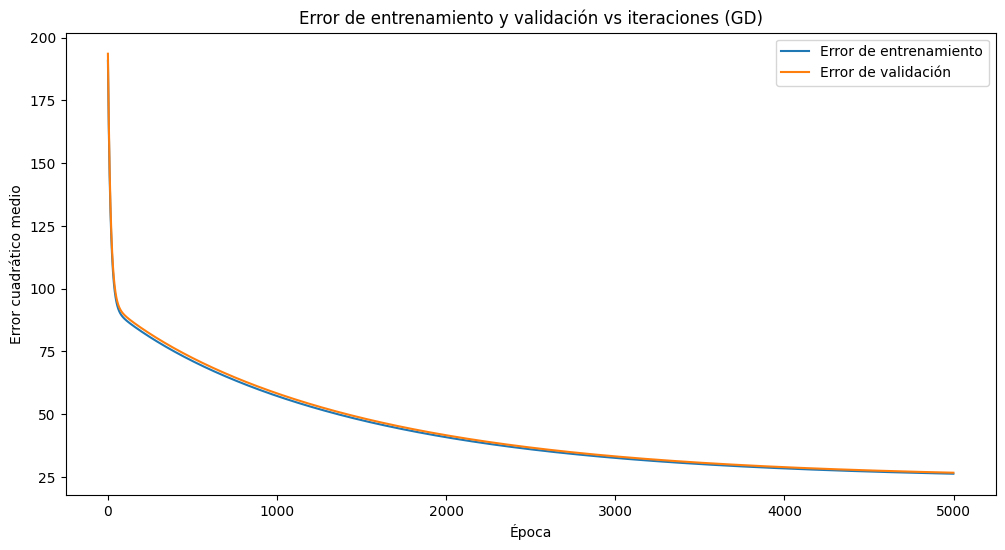

Error cuadrático medio (MSE):  26.72194583132471
Raíz del error cuadrático medio (RMSE):  5.169327406087247


In [79]:
lr_gd = 0.01
epochs_gd = 5000

w_valores_gd, train_errors_gd, test_errors_gd = gradient_descent(X_train_np, y_train_np, X_test_np, y_test_np, lr_gd, epochs_gd)
#MSE
mse_gd = test_errors_gd[-1] #Tomo el error de la ultima epoca
print("Error cuadrático medio (MSE): ", mse_gd)

#RMSE
rmse_gd = np.sqrt(mse_gd)
print("Raíz del error cuadrático medio (RMSE): ", rmse_gd)
#print('W: ', w_valores_gd)

Se observa que a medida que aumentan las epocas, el error va disminuyendo hasta tender a 5,16.
El error es mayor en comparacion al modelo de regresion lineal (5,16 vs 4.93).

### Gradiente Descendiente Estocastico

In [66]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=200):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W, train_errors, test_errors

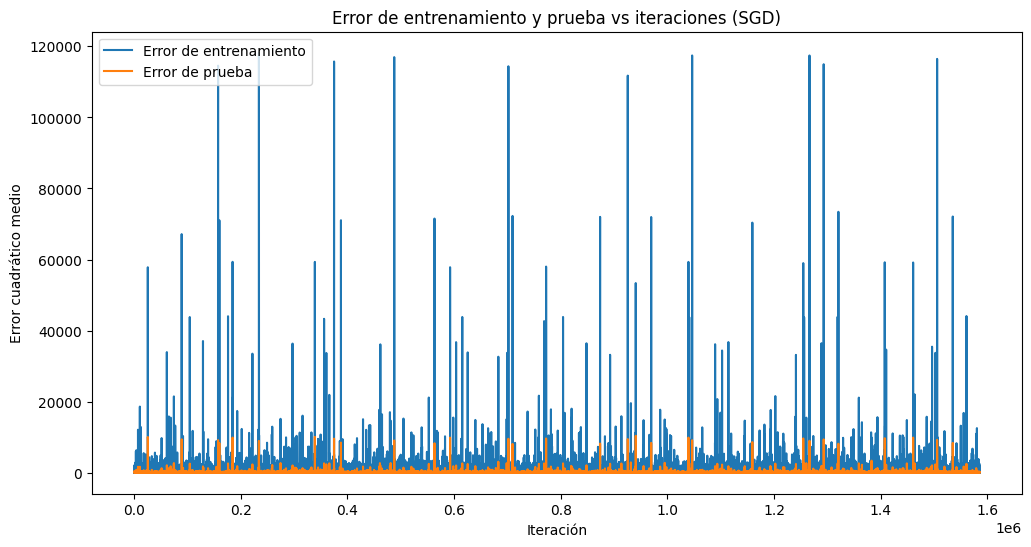

In [67]:
W_sto, train_errors, test_errors = stochastic_gradient_descent(X_train_np, y_train_np, X_test_np, y_test_np, lr=0.1, epochs=10)

In [70]:
#MSE
mse_gds = test_errors[-1] #Tomo el error de la ultima epoca
print("Error cuadrático medio (MSE): ", mse_gds)

#RMSE
rmse_gds = np.sqrt(mse_gds)
print("Raíz del error cuadrático medio (RMSE): ", rmse_gds)
#print('W: ', w_valores_gd)

Error cuadrático medio (MSE):  26.302363810542488
Raíz del error cuadrático medio (RMSE):  5.128583021707115


### Gradiente Descendiente Mini Batch

In [71]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W,train_errors,test_errors

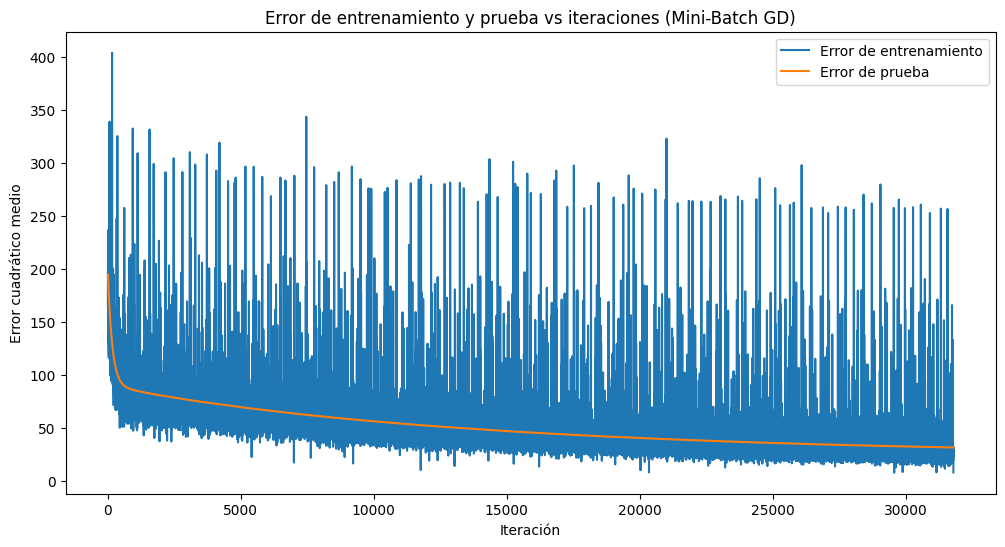

In [74]:
W_mb, train_errors_mb, test_errors_mb = mini_batch_gradient_descent(X_train_np, y_train_np, X_test_np, y_test_np, lr=0.001, epochs=100, batch_size=500)

In [75]:
#MSE
mse_mb = test_errors_mb[-1] #Tomo el error de la ultima epoca
print("Error cuadrático medio (MSE): ", mse_mb)

#RMSE
rmse_mb = np.sqrt(mse_mb)
print("Raíz del error cuadrático medio (RMSE): ", rmse_mb)
#print('W: ', w_valores_gd)

Error cuadrático medio (MSE):  31.826214179764108
Raíz del error cuadrático medio (RMSE):  5.6414726960044845


## Comparacion de modelos

In [83]:
np.set_printoptions(suppress=True, precision=4)

print("\nCoeficientes del modelo Linear Regression:")
print(np.round(lr.coef_,2))
print("RMSE: ", rmse_lr)
print('R2 - Train: ', r2_train_lr)
print('R2 - Test: ', r2_test_lr)

#print("\nCoeficientes del modelo con Gradiente Descendiente:")
#print([round(x, 2) for x in w_valores_gd.flatten()])
#print("RMSE: ", rmse_gd)
#print(f"LR: {lassoCV.alpha_} y Epocas: {epochs_gd}")

print("\nCoeficientes del modelo Ridge:")
print(np.round(ridge.coef_,2))
print("RMSE: ", rmse_ridge)
print("R2 - Train: ", r2_train_ridge )
print("R2 - Test: ", r2_test_ridge)
print(f"Mejor valor de alpha encontrado: {ridge.alpha_}")

print("\nCoeficientes del modelo Lasso:")
print(np.round(lassoCV.coef_,2))
print("RMSE: ", rmse_lasso)
print("R2 - Train: ", r2_train_lasso )
print("R2 - Test: ", r2_test_lasso)
print(f"Mejor valor de alpha encontrado: {lassoCV.alpha_}")

print("\nCoeficientes del modelo con Gradiente Descendiente:")
print([round(x, 2) for x in w_valores_gd.flatten()])
print("RMSE: ", rmse_gd)

print("\nCoeficientes del modelo con Gradiente Descendiente Estocastico:")
print([round(x, 2) for x in W_sto.flatten()])
print("RMSE: ", rmse_gds)

print("\nCoeficientes del modelo con Gradiente Mini Batch:")
print([round(x, 2) for x in W_mb.flatten()])
print("RMSE: ", rmse_mb)


Coeficientes del modelo Linear Regression:
[-0.31 -0.53 -1.35 -0.59 -1.12 61.85  0.09]
RMSE:  4.932422838345796
R2 - Train:  0.7314518585356857
R2 - Test:  0.7336545859820635

Coeficientes del modelo Ridge:
[-0.31 -0.53 -1.35 -0.59 -1.12 61.85  0.09]
RMSE:  4.932425997718582
R2 - Train:  0.7314518579549297
R2 - Test:  0.7336542447766357
Mejor valor de alpha encontrado: 0.07663410868007446

Coeficientes del modelo Lasso:
[-0.31 -0.53 -1.35 -0.59 -1.12 61.85  0.09]
RMSE:  4.932422838357498
R2 - Train:  0.7314518585356857
R2 - Test:  0.7336545859807997
Mejor valor de alpha encontrado: 1e-10

Coeficientes del modelo con Gradiente Descendiente:
[6.11, -0.27, -0.42, -1.15, -0.22, 0.55, 50.61, 0.08]
RMSE:  5.169327406087247

Coeficientes del modelo con Gradiente Descendiente Estocastico:
[4.93, -1.12, -2.88, -1.91, -0.48, -0.37, 61.16, 0.97]
RMSE:  5.128583021707115

Coeficientes del modelo con Gradiente Mini Batch:
[7.05, -0.25, -0.29, -0.95, -0.23, -1.54, 41.5, 0.08]
RMSE:  5.6414726960044

## Conclusion

En el modelo de regresión lineal se observa un R2 de 0.73, lo que indica que el modelo explica el 73% de la variabilidad de la variable objetivo (fare_amount). No se evidencia sobreajuste ni subajuste, ya que el desempeño es similar en los conjuntos de entrenamiento y prueba. Sin embargo, un 26% de la varianza permanece sin explicar, lo que sugiere la presencia de factores relevantes no capturados por el modelo.

El RMSE indica que, en promedio, el modelo se equivoca en aproximadamente 4.93 dólares al predecir el costo de un viaje. Por su parte, el MAPE del 29,14% significa que el modelo comete, en promedio, un error del 29% con respecto al valor real.

Al aplicar regularización, tanto con Ridge ni con Lasso, no se observa una mejora en el R2. Además, el RMSE tambien permanece similar. Por ende, se concluye que el modelo no mejora al aplicar regularizacion. Dicha situacion era esperable ya que las metricas del modelo original no nos otorgaban sospecha de sobreajuste.